#Installing MNE

In [ ]:
! pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 26.1 MB/s 


# Starting of the Time

In [ ]:
import time
start = time.time()

# Connecting Colab to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Necessary Libraries

In [ ]:
from glob import glob # it Is help us to read all files in the Folder 
import os
import mne # It is a Package which is Used to Analysis the EEG Dataset
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing Dataset

In [ ]:
all_file_path = glob('/content/drive/MyDrive/EC_Healthy_and_MDD_fif/*.fif')
print(len(all_file_path))

58


# Separating the Healthy Subjects and MDD Patients

In [ ]:
healthy_file_path = [i for i in all_file_path if 'h' in i.split('/')[5]]
patient_file_path = [i for i in all_file_path if 'm' in i.split('/')[5]]
print(len(healthy_file_path), len(patient_file_path))

28 30


#Reading the File Path and Getting the Data from One File

In [ ]:
def read_data(file_path):
    data = mne.io.read_raw_fif(file_path, preload = True)
    data.set_eeg_reference()
    data.filter(l_freq = 0.5, h_freq = 45)
    epochs = mne.make_fixed_length_epochs(data, duration = 5, overlap = 2)
    array = epochs.get_data()
    return array

In [ ]:
sample_data = read_data(healthy_file_path[0])

Opening raw data file /content/drive/MyDrive/EC_Healthy_and_MDD_fif/h10_ec_cropped_raw.fif...
Isotrak not found
    Range : 0 ... 96255 =      0.000 ...   375.996 secs
Ready.
Reading 0 ... 96255  =      0.000 ...   375.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 1691 samples (6.605 sec)

Not setting metadata
124 matching events found
No baseline correction applied
0 projection i

In [ ]:
sample_data.shape # no. of epochs, channels, length of signals 

(124, 20, 1280)

#Reading the File Path and Getting the Data from All File

In [ ]:
%%capture
control_epochs_array = [read_data(i) for i in healthy_file_path]
patient_epochs_array = [read_data(i) for i in patient_file_path]

In [ ]:
control_epochs_array[0].shape, control_epochs_array[1].shape, control_epochs_array[2].shape, control_epochs_array[3].shape, control_epochs_array[4].shape

((124, 20, 1280),
 (99, 20, 1280),
 (99, 20, 1280),
 (99, 20, 1280),
 (100, 20, 1280))

In [ ]:
patient_epochs_array[0].shape, patient_epochs_array[1].shape, patient_epochs_array[2].shape, patient_epochs_array[3].shape

((100, 20, 1280), (99, 20, 1280), (99, 20, 1280), (99, 20, 1280))

#Creating the Labels

In [ ]:
control_epochs_labels = [len(i)*[0] for i in control_epochs_array]
patient_epochs_labels = [len(i)*[1] for i in patient_epochs_array]
len(control_epochs_labels), len(patient_epochs_labels)

(28, 30)

#Combining Both the Healthy and MDD Files

In [ ]:
data_list = control_epochs_array + patient_epochs_array
label_list = control_epochs_labels + patient_epochs_labels

#Spletting the Dataset in the Basis of Subjects


In [ ]:
epochs_array=control_epochs_array+patient_epochs_array
epochs_labels=control_epochs_labels+patient_epochs_labels
print(len(epochs_array),len(epochs_labels))

58 58


# Creating Groups

In [ ]:
groups = [[i]*len(j) for i,j in enumerate(data_list)]
len(groups)

58

# Converting the Data from List to array


In [ ]:
data_array = np.vstack(data_list)
label_array = np.hstack(label_list)
groups_array = np.hstack(groups)
print(data_array.shape, label_array.shape, groups_array.shape)

(5735, 20, 1280) (5735,) (5735,)


# Feature Extraction

In [ ]:
from scipy import stats

def mean(x):
    return np.mean(x,axis=-1)
def std(x):  
    return np.std(x,axis=-1)
def ptp(x):
    return np.ptp(x,axis=-1)
def var(x):
    return np.var(x,axis=-1)
def minim(x):
    return np.min(x,axis=-1)
def maxim(x):
    return np.max(x,axis=-1)
def argminim(x):
    return np.argmin(x,axis=-1) 
def argmaxim(x):
    return np.argmax(x,axis=-1)   
                   
def abs_diff_signals(x):
    return np.sum(np.abs(np.diff(x,axis=-1)),axis=-1)
def skewness(x):
    return stats.skew(x,axis=-1)
def kurtosis(x):
    return stats.kurtosis(x,axis=-1)
#def rms(x):
#    return np.sqrt(np.mean(x**2,axis=-1)
def concatenate_features(x):
    return np.concatenate((mean(x),std(x),ptp(x),var(x),minim(x),maxim(x),argminim(x),argmaxim(x),abs_diff_signals(x),\
                           skewness(x),kurtosis(x)),axis=-1) 

# Loop to Extract the Features

In [ ]:
features=[]
for d in data_array:
    features.append(concatenate_features(d))

# Converting the Features list into Features Arrays

In [ ]:
features_array=np.array(features)
features_array.shape

(5735, 220)

In [ ]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(features_array,label_array,test_size=0.20, shuffle=True)



In [ ]:
# applying the scaler
sc_x = StandardScaler()
#fiting the train data for the transformation for model 
xtrain = sc_x.fit_transform(xtrain) 
#fiting the test data for the transformation for model 
xtest = sc_x.transform(xtest)



In [ ]:
 
# applying the classifier
classifier = svm.SVC() 
# allpying the model
classifier.fit(xtrain, ytrain)
# applying the data for the prediction
y_pred = classifier.predict(xtest)
# cheking the confusion Matrix


In [ ]:
cm = confusion_matrix(ytest, y_pred)

In [ ]:
print ("Confusion Matrix : \n", cm)
cm[1][1]
# cheking the accuracy of model
print ("Accuracy : ", accuracy_score(ytest, y_pred))

Confusion Matrix : 
 [[445 127]
 [ 26 549]]
Accuracy :  0.8666085440278989


In [ ]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives


In [ ]:
# sensitivity 
sense = TP / (TP+FN)
print("The sensitivity of model is:",sense)


# specificity  
speci = TN / (TN+FP)
print("The specificity of model is:",speci)


The sensitivity of model is: 0.9547826086956521
The specificity of model is: 0.777972027972028


In [ ]:

#ROC

# Defining the function to plot the ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

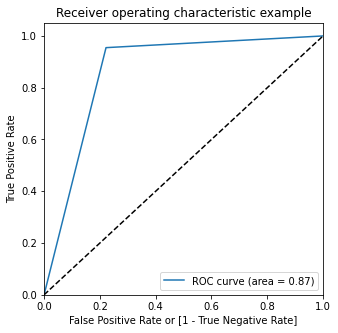

In [ ]:

# Calling the function
draw_roc(ytest, y_pred)

from sklearn.metrics import cohen_kappa_score
k = cohen_kappa_score(ytest, y_pred)


In [ ]:

print("The kappa score is:",k)
end = time.time()
print("Total time in sec:",end - start)



The kappa score is: 0.7330923182919467
Total time in sec: 734.3530869483948


# SVM for Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV

In [ ]:
clf=SVC()
gkf=GroupKFold(5)
pipe=Pipeline([('scalar',StandardScaler()),('clf',clf)])
param_grid={'clf__C':[0.1,0.3,0.5,0.7,1,3,5,7]}
gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=12)
gscv.fit(features_array,label_array,groups=groups_array)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('clf', SVC())]),
             n_jobs=12,
             param_grid={'clf__C': [0.1, 0.3, 0.5, 0.7, 1, 3, 5, 7]})

# Accuracy

In [ ]:
gscv.best_score_

0.7190646906758194

# End of the Time

In [ ]:
end = time.time()
print("Total time in sec:",end - start)

Total time in sec: 253.57270431518555
